In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [32]:
base_dir = "./archive"

train_cat_path = os.path.join(base_dir, "training_set", "training_set", "cats")
test_cat_path = os.path.join(base_dir, "test_set", "test_set", "cats")
train_dog_path = os.path.join(base_dir, "training_set", "training_set", "dogs")
test_dog_path = os.path.join(base_dir, "test_set", "test_set", "dogs")

In [33]:
def read_image_set(path, gray_scale = False, target_shape = (200, 200)):
    animals = []
    for file in tqdm(os.listdir(path)):
        current_img = plt.imread(os.path.join(path, file))
        current_img = cv2.resize(current_img, target_shape)
        # Convert to grayscale
        if gray_scale:
            current_img = cv2.cvtColor(current_img, cv2.COLOR_RGB2GRAY)
        animals.append(current_img)
    return animals

In [34]:
print(f"Reading cat images...")
cats = read_image_set(train_cat_path, gray_scale = False)

print(f"Reading dog images...")
dogs = read_image_set(train_dog_path, gray_scale = False)

  1%|          | 38/4000 [00:00<00:10, 377.89it/s]

Reading cat images...


  1%|▏         | 52/4005 [00:00<00:07, 518.79it/s]

Reading dog images...


100%|██████████| 4005/4005 [00:07<00:00, 556.88it/s]


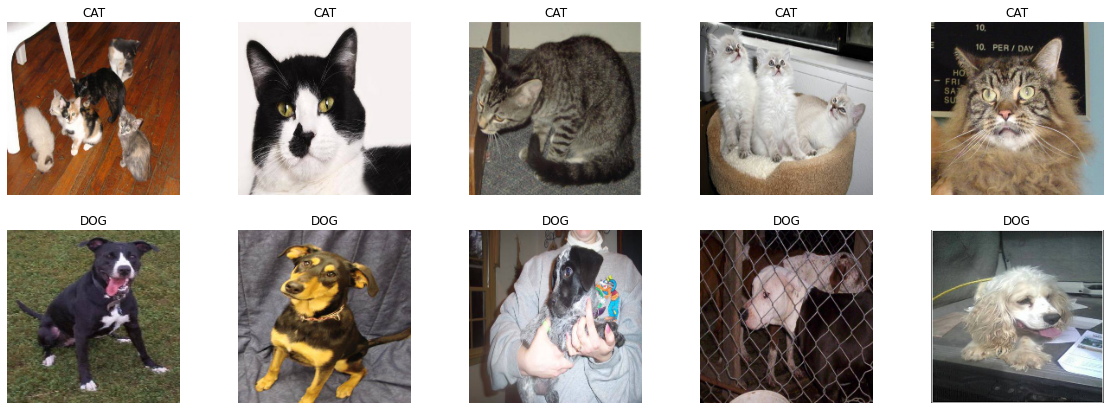

In [35]:
num_images = 5
_, axes = plt.subplots(2, num_images, figsize=(20, 7))

for i in range(num_images):
    axes[0, i].imshow(cats[random.randint(0, len(cats)-1)])
    axes[0, i].axis("off")
    axes[0, i].set_title("CAT")
    
    axes[1, i].imshow(dogs[random.randint(0, len(dogs)-1)])
    axes[1, i].axis("off")
    axes[1, i].set_title("DOG")
    
plt.show()

In [36]:
#Create the training set
from sklearn.model_selection import train_test_split

training = cats + dogs
training_labels = [1]*len(cats) + [0]*len(dogs)

train_data, val_data, train_labels, val_labels = train_test_split(training, training_labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = np.array(train_data), np.array(val_data), np.array(train_labels), np.array(val_labels)

#train_data = tf.expand_dims(train_data, axis=-1)
#val_data = tf.expand_dims(val_data, axis=-1)

print(f"Size of train data {train_data.shape}, size of labels {train_labels.shape}")
print(f"Size of validation data {val_data.shape}, size of labels {val_labels.shape}")

images_shape = train_data[0].shape

Size of train data (6404, 200, 200, 3), size of labels (6404,)
Size of validation data (1601, 200, 200, 3), size of labels (1601,)


In [62]:
# Create network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=images_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_31 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
# Train network
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = 32,
    epochs = 50,
    validation_data = (val_data, val_labels)
)

Epoch 1/50
201/201 [==============================] - 195s 967ms/step - loss: 0.6563 - accuracy: 0.6116 - val_loss: 0.6351 - val_accuracy: 0.6084
Epoch 2/50
201/201 [==============================] - 194s 965ms/step - loss: 0.5763 - accuracy: 0.6972 - val_loss: 0.6077 - val_accuracy: 0.6658
Epoch 3/50
201/201 [==============================] - 193s 962ms/step - loss: 0.5277 - accuracy: 0.7363 - val_loss: 0.6392 - val_accuracy: 0.6327
Epoch 4/50
201/201 [==============================] - 200s 993ms/step - loss: 0.4785 - accuracy: 0.7697 - val_loss: 0.5168 - val_accuracy: 0.7601
Epoch 5/50
201/201 [==============================] - 195s 970ms/step - loss: 0.4174 - accuracy: 0.8086 - val_loss: 0.5113 - val_accuracy: 0.7783
Epoch 6/50
201/201 [==============================] - 199s 992ms/step - loss: 0.3411 - accuracy: 0.8454 - val_loss: 0.6029 - val_accuracy: 0.7327
Epoch 7/50
201/201 [==============================] - 195s 970ms/step - loss: 0.2844 - accuracy: 0.8746 - val_loss: 0.5727 -

In [ ]:
# Evaluate
